# Lecture 24 : GPU Collatz

# Version 1 : One Thread Block

### Let's start the development of a CUDA kernel for finding the largest total stopping time.

### Version 1 of the collatz kernel is written in the style of our final sum kernel (version 6).

### Since the function *total_stopping_time* is called by the kernel we put *\_\_device\_\_* before the function definition.

### Note the use of atomicExch (atomic exchange) to keep track of the starting value with the largest total stopping time.

In [ ]:
%%writefile gpu_collatz_v1.cu
#include <stdio.h>
#include <stdlib.h>
#include <cuda.h>

typedef unsigned int uint32;
typedef unsigned long long int uint64;

/* compute the total stopping time of a given start value */
__device__ uint32 total_stopping_time (uint64 start) {
    uint32 total = 0;
    uint64 a_i = start;
    while (a_i != 1) {
        total += 1;
        if (a_i % 2 == 0) {
            a_i /= 2;
        } else {
            a_i = 3*a_i + 1;
        }
    }
    return total;
}

__global__ void collatzKernel(uint64 N) {

    __shared__ uint64 max_start;
    __shared__ uint32 max_total;

    int thread_num = threadIdx.x;
    int num_threads = blockDim.x;

    if (thread_num == 0) {
        max_start = 1;
        max_total = 0;
    }
    __syncthreads();

    uint64 thread_max_start = 1;
    uint32 thread_max_total = 0;
    for (uint64 n = 1+thread_num;n<=N;n+=num_threads) {
        uint32 total = total_stopping_time(n);
        if (total > thread_max_total) {
            thread_max_start = n;
            thread_max_total = total;
        }
    }
    atomicMax(&max_total,thread_max_total);
    __syncthreads();

    if (max_total == thread_max_total) {
        atomicExch(&max_start,thread_max_start);
    }
    __syncthreads();

    if (thread_num == 0) {
        /* output the results */
        printf ("The starting value less than or equal to %llu\n",N);
        printf ("  having the largest total stopping time is %llu\n",max_start);
        printf ("  which has %u steps\n",max_total);
    }
}

int main (int argc, char** argv) {

    /* get N and num_threads from the command line */
    if (argc < 3) {
        printf ("Command usage : %s %s %s\n",argv[0],"N","num_threads");
        return 1;
    }

    uint64 N = atol(argv[1]);
    int num_threads = atoi(argv[2]);

    printf ("num_threads = %d\n",num_threads);
    collatzKernel <<< 1, num_threads >>> (N);
    cudaDeviceSynchronize();
}

In [ ]:
!nvcc -arch=sm_75 -o gpu_collatz_v1 gpu_collatz_v1.cu

In [ ]:
!time ./gpu_collatz_v1 100000000 256

### Using version 1 of the collatz kernel with 256 threads we can easily handle $N$ values up to around 100 million.

### Discussion: What is the major limitation of the version 1 kernel?

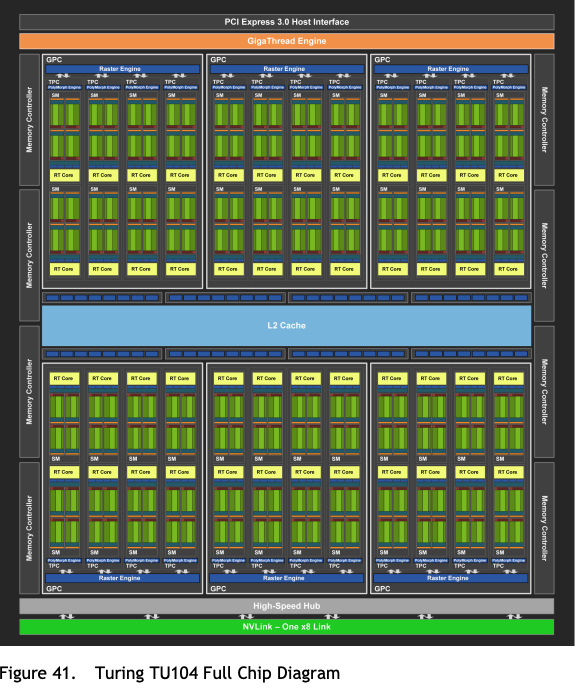

### How do we unleash the full power of the GPU?  

### We will need to use more than one thread block in order to make use of every SM on the GPU.  

### This will require us to use substantially more threads.  

### Discussion: What is the smallest amount of work we can assign to each thread?  

### For example, if we have 10000 dishes to wash what is the smallest amount of work we could have each dishwasher do?  How many dishwashers would we need in this case?

### If we want to check all starting values at or below 1 million for the largest total stopping time what is the smallest amount of work we could have each thread do?  How many threads would we need in this case?

# Version 2 : One Billion Threads

### For kernel version 2, we assign each thread the task of computing a total stopping time for a single number.  

### For this kernel version we bump $N$ up to 1 billion.

### That means that we will need 1 billion threads!  

### We group the threads into thread blocks.  While threads in the same thread block all have to run on the same SM, different thread blocks can run on different SMs in parallel.  

### Once we specify the number of threads per block (we call this parameter B), then the minimum number of thread blocks required is the ceiling of $N/B$.

### We can compute the ceiling of $N/B$ using only integer arithmetic using the formula: $G=(N+B-1)/B$.

### For example, if $N = 100$ and $B = 32$ then $G=(N+B-1)/B = (100+32-1)/32 = 4$ which makes sense in this case since we will thread 4 thread blocks.

### Note that when N is not a multiple of B, there will be some extra threads that will end up idling.

### Note that line 26 in the version 2 kernel ensures that the extra threads idle.

### To compute the thread number we use the CUDA code

*blockIdx.x * blockDim.x + threadIdx.x*

### This formula multiplies the *block index* times the *number of threads per block* and adds in the *thread index*.  

### For example, consider the case where you have 32 thread blocks of 32 threads each.  

### If the block index is 25 and the thread index is 15, what is the thread number?

### Answer : 25*32+15 = 815

### If the thread number is $765$, what is the block index and thread index?

### Answer part 1: To find the block index we use the integer division formula $765 / 32 = 23$.  

### Answer part 2: To find the thread index we use the mod formula $765 \text{ mod } 32 = 765 - 23*32 = 29$.  

### To ensure the kernel works we have the thread that found the largest total stopping time under 1 billion print.

### From the Collatz Wiki page, we get the largest total stopping time for staring values at or under 1 billion is 986.

In [ ]:
%%writefile gpu_collatz_v2.cu
#include <stdio.h>
#include <stdlib.h>
#include <cuda.h>

typedef unsigned int uint32;
typedef unsigned long long int uint64;

/* compute the total stopping time for a given number n */
__device__ uint32 total_stopping_time (uint64 a_i) {
    uint32 total = 0;
    while (a_i != 1) {
        if (a_i % 2 == 0) {
            a_i = a_i/2;
        } else {
            a_i = (3*a_i+1);
        }
        total += 1;
    }
    return total;
}

__global__ void collatzKernel(uint64 N) {

    int thread_num = blockIdx.x*blockDim.x + threadIdx.x;
    if (thread_num < N) {
        uint32 total = total_stopping_time(thread_num+1);
        if (total == 986) {
            printf ("starting value n = %d has total stopping time 986\n",thread_num+1);
        }
    }
}

int main (int argc, char** argv) {

    /* B is the number of threads per block */
    /* we typically choose B to be a multiple of 32 */
    /* the maximum value of B is 1024 */
    /* get N and B from the command line */
    if (argc < 3) {
        printf ("Command usage : %s %s %s\n",argv[0],"N","B");
        return 1;
    }
    uint64 N = atol(argv[1]);
    int B = atoi(argv[2]);

    /* G is the number of thread blocks */
    /* the maximum number of thread blocks G is 2^31 - 1 = 2147483647 */
    /* We choose G to be the minimum number of thread blocks to have at least N threads */
    int G = (N+B-1)/B;
    printf ("N = %llu\n",N);
    printf ("threads per block B = %d\n",B);
    printf ("number of thread blocks G = %d\n",G);
    printf ("number of threads G*B = %d\n",G*B);
    collatzKernel <<< G, B >>> (N);
    cudaDeviceSynchronize();
}

In [ ]:
!nvcc -arch=sm_75 -o gpu_collatz_v2 gpu_collatz_v2.cu

In [ ]:
!time ./gpu_collatz_v2 1000000000 256

### Version 2 of the kernel is not complete since we are using the fact that we already know the answer.

###  Although the return value of a CUDA kernel is *void*, a kernel can return values using pointers.  

### Consider the following version of the CUDA Collatz kernel.

```c
__global__ void collatzKernel(uint64 N, uint32* totals) {

    int thread_num = blockIdx.x*blockDim.x + threadIdx.x;
    if (thread_num < N) {
        totals[thread_num] = total_stopping_time(thread_num+1);
    }
}
```

### In this kernel, each thread is writing the total stopping time it computed to the array *totals*.

### As the figure below shows, the device (GPU) and host (CPU) each have their own separate memory.  

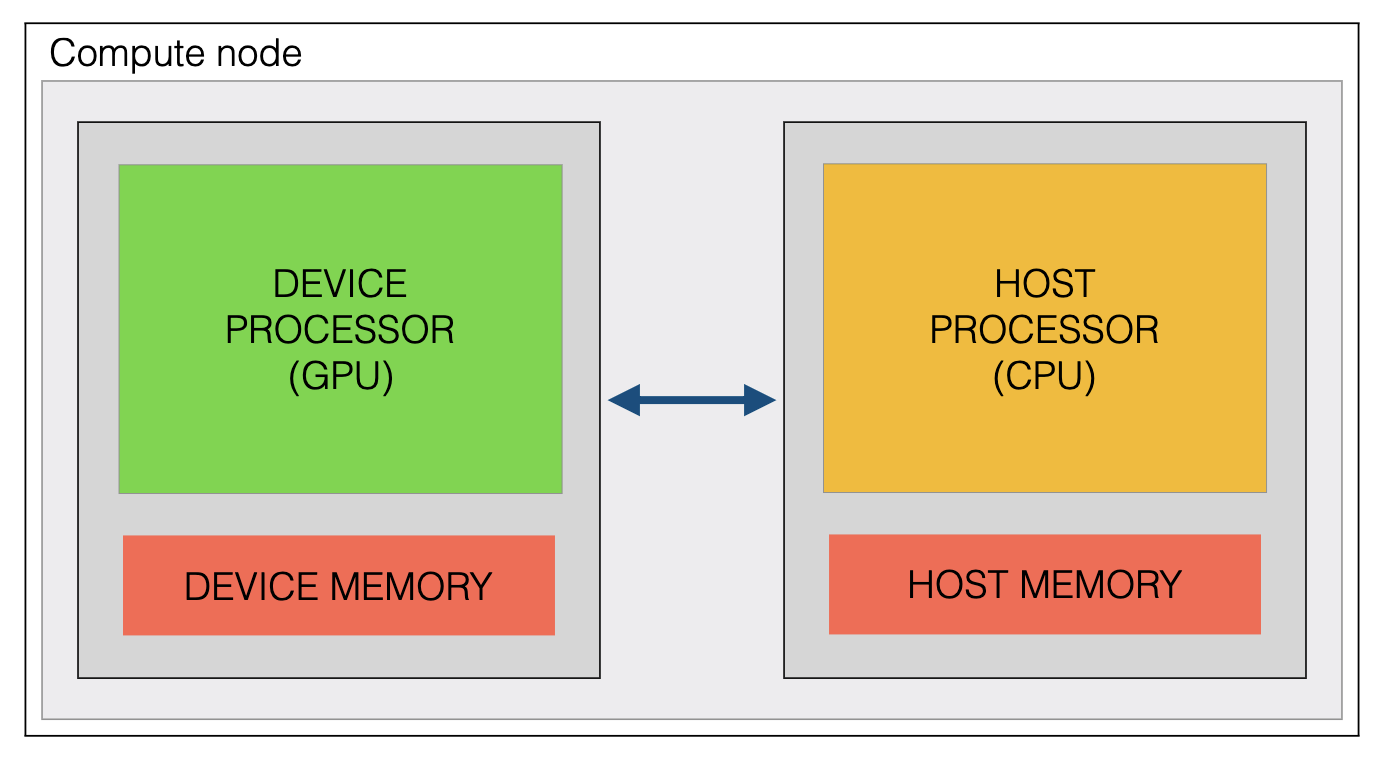

# Version 3 : Threads Returning Values

### In version 3 of the kernel, each thread running on the device (GPU) returns the *total\_stopping\_time* it computed to the host (CPU).  

### The CPU then (sequentially) processes the information from the GPU to determine the maximum total stopping time as well as the corresponding start value.

### A thread running on the device (GPU) can only access device memory.  

### The host (CPU) can access host memory and also allocate and access device memory using special CUDA functions such as cudaMalloc, cudaMemcpy, cudaFree, etc.

### The host has to allocate device memory for the *totals* array that the threads will write their return values to.  

### This device memory allocation of the *totals* array is done using the cudaMalloc.  

### Notice the corresponding call to cudaFree.  

### There is also a host memory version of the *totals* array.  

### After the threads finish writing their values to the device *totals* array, the host copies the device array to the host array using cudaMemcpy.  

### Note that the cudaMemcpy call after the kernel launch also synchronizes the device and so we can delete the function call *cudaDeviceSynchronize()* in this version.

In [ ]:
%%writefile gpu_collatz_v3.cu
#include <stdio.h>
#include <stdlib.h>
#include <cuda.h>

typedef unsigned int uint32;
typedef unsigned long long int uint64;

/* compute the total stopping time for a given number n */
__device__ uint32 total_stopping_time (uint64 a_i) {
    uint32 total = 0;
    while (a_i != 1) {
        if (a_i % 2 == 0) {
            a_i = a_i/2;
        } else {
            a_i = (3*a_i+1);
        }
        total += 1;
    }
    return total;
}

__global__ void collatzKernel(uint64 N, uint32* d_totals) {

    int thread_num = blockIdx.x*blockDim.x + threadIdx.x;
    if (thread_num < N) {
        d_totals[thread_num] = total_stopping_time(thread_num+1);
    }
}

int main (int argc, char** argv) {

    /* B is the number of threads per block */
    /* we typically choose B to be a multiple of 32 */
    /* the maximum value of B is 1024 */
    /* get N and B from the command line */
    if (argc < 3) {
        printf ("Command usage : %s %s %s\n",argv[0],"N","B");
        return 1;
    }
    uint64 N = atol(argv[1]);
    int B = atoi(argv[2]);

    /* G is the number of thread blocks */
    /* the maximum number of thread blocks G is 2^31 - 1 = 2147483647 */
    /* We choose G to be the minimum number of thread blocks to have at least N threads */
    int G = (N+B-1)/B;
    printf ("N = %llu\n",N);
    printf ("threads per block B = %d\n",B);
    printf ("number of thread blocks G = %d\n",G);
    printf ("number of threads G*B = %d\n",G*B);

    /* the totals array in host memory */
    uint32* totals = (uint32*)malloc(N*sizeof(uint32));

    /* the totals array in device memory */
    uint32* d_totals;
    cudaMalloc (&d_totals,N*sizeof(uint32));

    /* launch kernels */
    collatzKernel <<< G, B >>> (N,d_totals);

    /* copy total stopping time data from device to host */
    cudaMemcpy (totals, d_totals, N*sizeof(uint32),cudaMemcpyDeviceToHost);

    /* host uses totals array to find the largest total stopping time */
    uint64 max_start = 1;
    uint32 max_total = 0;
    for (uint64 n = 1;n<=N;n++) {
        uint32 total = totals[n-1];
        if (total > max_total) {
            max_start = n;
            max_total = total;
        }
    }

    /* output the results */
    printf ("The starting value less than or equal to %llu\n",N);
    printf ("  having the largest total stopping time is %llu\n",max_start);
    printf ("  which has %u steps\n",max_total);

    /* free the memory on the host */
    free (totals);

    /* free the memory on the device */
    cudaFree (d_totals);
}

In [ ]:
!nvcc -arch=sm_75 -o gpu_collatz_v3 gpu_collatz_v3.cu

In [ ]:
!time ./gpu_collatz_v3 1000000000 256

### Version 3 calculates the correct answer (without cheating!).

### Discussion : Why does version 3 take around 6 times longer to run than version 2 with the same value of N?

### Hint: How many bytes of memory must be copied from the device to the host?

# Version 4 : Thread Blocks Returning Values

### We can dramatically reduce the amount of memory copied from the device to the host by having each thread block return a value to the host rather than each thread.

### We can accomplish this be having threads within the same thread block cooperate to choose the block level maximum total stopping time (i.e. perform a *max reduction*).  

### Recall that threads within the same thread block all run on the same SM and thus have access to shared variables.  

### This is the approach we used in version 1 of the kernel.  

### The difference between version 4 and version 1 is that we use multiple thread blocks to unleash the entire GPU.

In [ ]:
%%writefile gpu_collatz_v4.cu
#include <stdio.h>
#include <stdlib.h>
#include <cuda.h>

typedef unsigned int uint32;
typedef unsigned long long int uint64;

/* compute the total stopping time for a given number n */
__device__ uint32 total_stopping_time (uint64 a_i) {
    uint32 total = 0;
    while (a_i != 1) {
        if (a_i % 2 == 0) {
            a_i = a_i/2;
        } else {
            a_i = (3*a_i+1);
        }
        total += 1;
    }
    return total;
}

__global__ void collatzKernel(uint64 N, uint64* d_starts, uint32* d_totals) {

    __shared__ uint64 max_start;
    __shared__ uint32 max_total;

    if (threadIdx.x == 0) {
        max_start = 1;
        max_total = 0;
    }
    __syncthreads();

    uint64 thread_num = (uint64)blockIdx.x*blockDim.x + threadIdx.x;
    uint32 total = 0;
    if (thread_num < N) {
        total = total_stopping_time(thread_num+1);
    }
    atomicMax(&max_total,total);
    __syncthreads();
    if (max_total == total) {
        atomicExch(&max_start,thread_num+1);
    }
    __syncthreads();

    if (threadIdx.x == 0) {
        d_starts[blockIdx.x] = max_start;
        d_totals[blockIdx.x] = max_total;
    }

}

int main (int argc, char** argv) {

    /* B is the number of threads per block */
    /* we typically choose B to be a multiple of 32 */
    /* the maximum value of B is 1024 */
    /* get N and B from the command line */
    if (argc < 3) {
        printf ("Command usage : %s %s %s\n",argv[0],"N","B");
        return 1;
    }
    uint64 N = atol(argv[1]);
    int B = atoi(argv[2]);

    /* G is the number of thread blocks */
    /* the maximum number of thread blocks G is 2^31 - 1 = 2147483647 */
    /* We choose G to be the minimum number of thread blocks to have at least N threads */
    int G = (N+B-1)/B;
    printf ("N = %llu\n",N);
    printf ("threads per block B = %d\n",B);
    printf ("number of thread blocks G = %d\n",G);
    printf ("number of threads G*B = %llu\n",(uint64)G*B);

    /* the starts and totals arrays in host memory */
    uint64* starts = (uint64*)malloc(G*sizeof(uint64));
    uint32* totals = (uint32*)malloc(G*sizeof(uint32));

    /* the totals array in device memory */
    uint64* d_starts;
    uint32* d_totals;
    cudaMalloc (&d_starts,G*sizeof(uint64));
    cudaMalloc (&d_totals,G*sizeof(uint32));

    /* launch kernels */
    collatzKernel <<< G, B >>> (N,d_starts,d_totals);

    /* copy total stopping time data from device to host */
    cudaMemcpy (starts, d_starts, G*sizeof(uint64),cudaMemcpyDeviceToHost);
    cudaMemcpy (totals, d_totals, G*sizeof(uint32),cudaMemcpyDeviceToHost);

    /* host finds the largest total stopping time */
    uint64 max_start = 1;
    uint32 max_total = 0;
    for (int b=0;b<G;b++) {
        if (totals[b] > max_total) {
            max_start = starts[b];
            max_total = totals[b];
        }
    }

    /* output the results */
    printf ("The starting value less than or equal to %llu\n",N);
    printf ("  having the largest total stopping time is %llu\n",max_start);
    printf ("  which has %u steps\n",max_total);

    /* free the memory on the host */
    free (totals);

    /* free the memory on the device */
    cudaFree (d_totals);
}

In [ ]:
!nvcc -arch=sm_75 -o gpu_collatz_v4 gpu_collatz_v4.cu

In [ ]:
!time ./gpu_collatz_v4 1000000000 256

### Version 4 calculates the correct answer (without cheating!) and runs almost as fast as version 2!

### Let's push N to 10 billion!


In [ ]:
!time ./gpu_collatz_v4 10000000000 256

### The maximum total stopping time of 1132 steps matches the Collatz Wiki page.

### We can divide the runtime by 4 by using the more modern GeForce RTX 4090 GPU.  

```
jasonwil@twnvws2:~/gpu_collatz$ time gpu_collatz_v4 10000000000 256
N = 10000000000
threads per block B = 256
number of thread blocks G = 39062500
number of threads G*B = 10000000000
The starting value less than or equal to 10000000000
    having the largest total stopping time is 9780657631
    which has 1132 steps

real	0m2.458s
user	0m2.133s
sys	 0m0.324s
jasonwil@twnvws2:~/gpu_collatz$
```

### Note: One major difference is that the RTX 4090 (2022) has 128 SMs versus the 40 SMs on the T4 (2018).

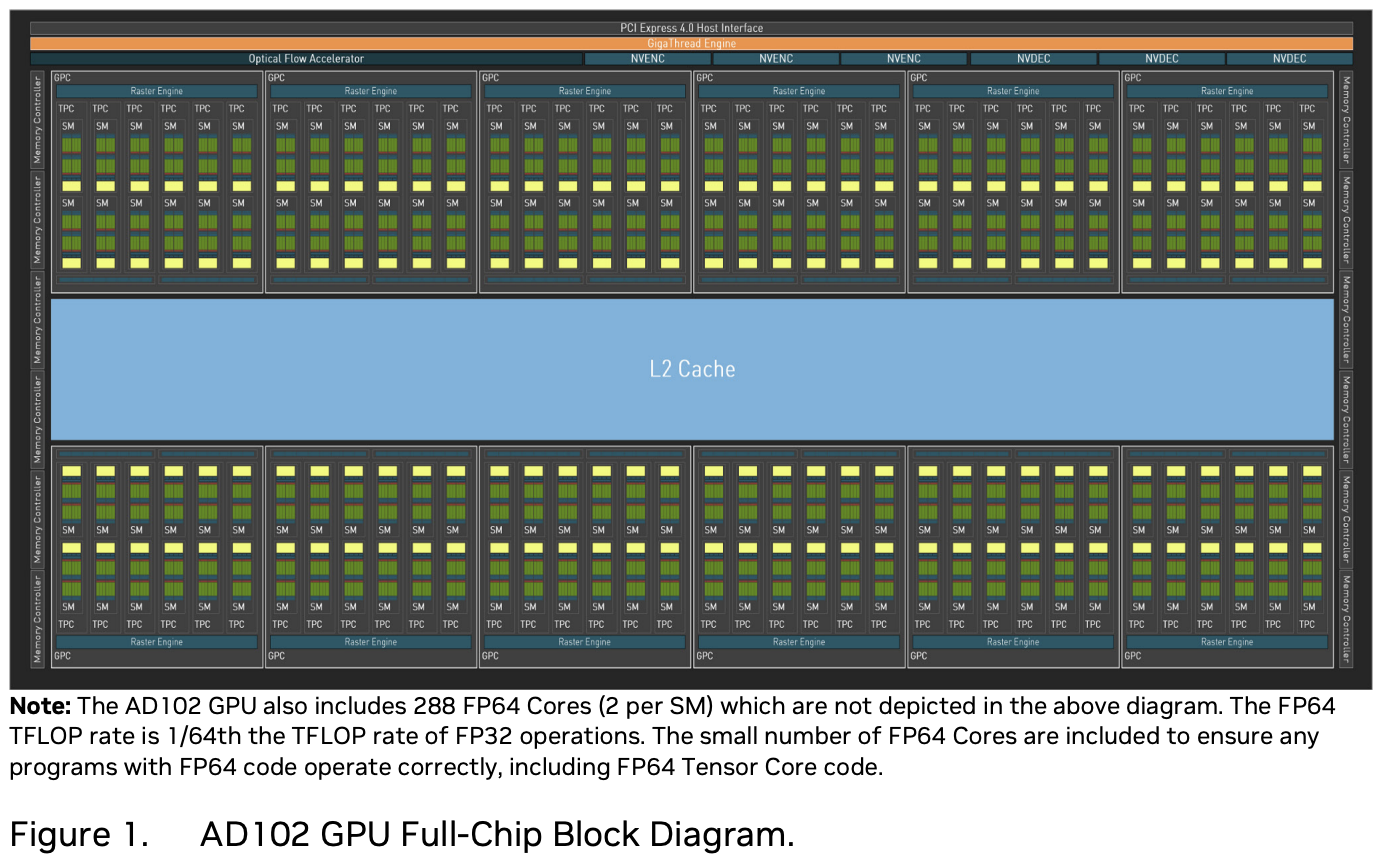

### Unfortunately, going past an N of 10 billion will cause overflow as the intermediate terms of the Collatz sequence get very large (even bigger than we can store in an unsigned 64 bit integer).  

### We can solve the overflow problem by using 128 bit integers but since they are not supported natively on the GPU we would have to create our own 128 bit integer datatype (exercise!).